In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from tqdm import tqdm

In [2]:

def euler_Method(S0, interest_rate, delta_t, N, volatality):
    """
    Euler method for stock price simulation 

    Args:
        S0 : Stock price at time 0
        interest_rate : Risk free interest rate
        delta_t : Time step
        N : Number of time steps
        volatality : Volatality of the stock

    Returns:
        stock_prices : Stock prices for N time steps
    """
    prev_S = S0
    stock_prices = np.zeros(N)
    stock_prices[0] = prev_S
    for i in range(1, N):
        Zm = norm.rvs()
        next_S = prev_S * ( 1 + interest_rate * delta_t + volatality * np.sqrt(delta_t) * Zm )
        prev_S = next_S
        stock_prices[i] = next_S
    return stock_prices

In [4]:
def confidence_interval(data):
        """
        Function to calculate confidence interval

        Args:
            data: Data for which confidence interval is to be calculated

        Returns:
                m-h, m+h : Lower and upper bounds of the confidence interval
        """
        a = data.shape[0]
        m, sd = np.mean(data), np.std(data)
        h = 1.96*sd/np.sqrt(a)
        return m - h, m + h

In [5]:
def priceOption(S0, r, delta_t, N, sigma, K, M, option_type):
    """
    Function to price the option using Monte Carlo simulation  
    Args:
        S0 : Stock price at time 0
        r : Risk free interest rate
        delta_t : Time step
        N : Number of time steps
        sigma : Volatality of the stock
        K : Strike price
        M : Number of simulations
        option_type : Type of option (call/put)
    Returns:
        price_option : Price of the option
        std_error : Standard error
        ml : Lower bound of the confidence interval 
        mu : Upper bound of the confidence interval
    """
    
    pay_offs = np.zeros(M)
    T  = N * delta_t
    for i in range(M):
        stock_price_N = (euler_Method(S0, r, delta_t, N, sigma))[-1]
        if option_type == "call":
            pay_off  = max(stock_price_N - K, 0)
        else:
            pay_off = max(K - stock_price_N, 0)
        pay_offs[i] = pay_off
    ml, mu = confidence_interval(pay_offs * np.exp(-r*T))
    price_option = np.exp(-r*T) * np.mean(pay_offs)
    std_error = np.std(pay_offs) / np.sqrt(M)
    
    return price_option, std_error, ml, mu

In [6]:
def blackScholes(current_stock_price, strike_price, current_time, maturity_time, interest_rate, volatality):
    
    tao = maturity_time - current_time
    d1 = (np.log(current_stock_price/strike_price) + (interest_rate + volatality**2/2) * tao)/(volatality*np.sqrt(tao))
    d2 = d1 - volatality * np.sqrt(tao)
    option_price =  - current_stock_price * norm.cdf(-d1) + np.exp(-interest_rate * tao) * strike_price * norm.cdf(-d2)
    
    return option_price

In [8]:
# Parameters
T = 1.0
K = 99
r = 0.06
S0 = 100 
sigma = 0.2
delta_t = 1/252
N = int(T/delta_t)
# Option price from black scholes
option_BS = blackScholes(S0, K, 0, T, r, sigma)

In [7]:
m = np.arange(100, 10000, 100)
option_values = []
std_errors = []
lower = []
upper = []
# Monte Carlo Simulation for option pricing
for M in tqdm(m):
    option_value, sd_error , ml, mu   = priceOption(S0, r, delta_t, N, sigma, K, M,"put")
    option_values.append(option_value)
    std_errors.append(sd_error)
    lower.append(ml)
    upper.append(mu)

100%|██████████| 99/99 [16:08<00:00,  9.79s/it]


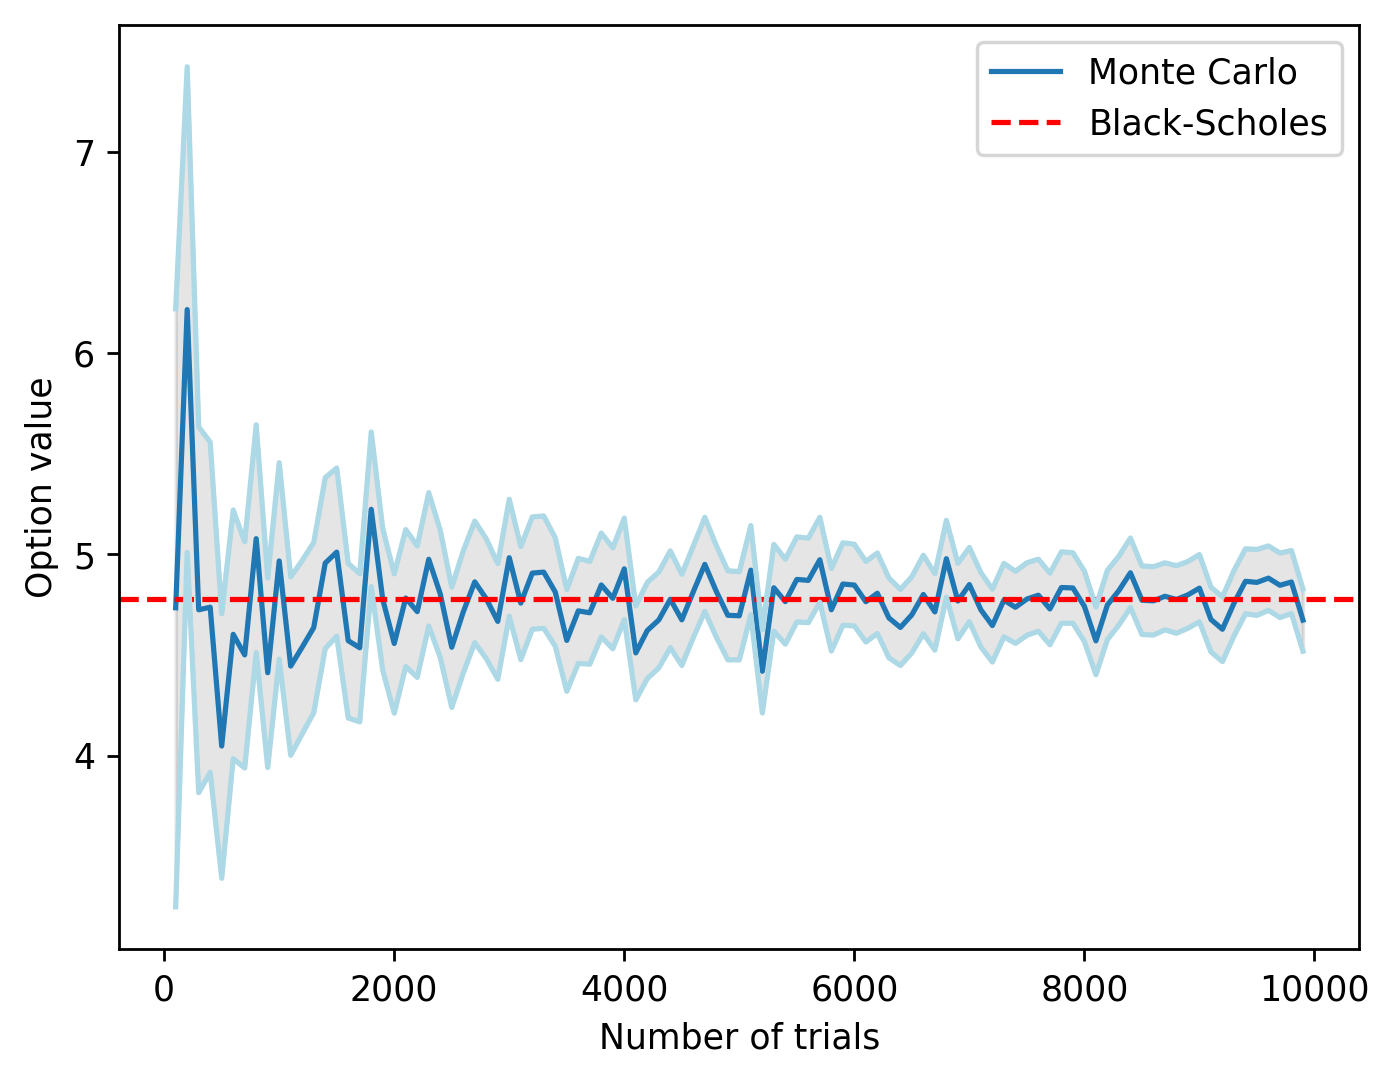

In [23]:
plt.figure(dpi=250)
plt.plot(m, option_values, label='Monte Carlo')
plt.axhline(option_BS, linestyle = "--", color = "red", label="Black-Scholes")
plt.plot(m, upper,color = "lightblue")
plt.plot(m, lower, color = "lightblue")
plt.fill_between(m, upper, lower, color="k", alpha=0.1)
plt.xlabel("Number of trials")
plt.ylabel("Option value")
plt.legend()
plt.show()

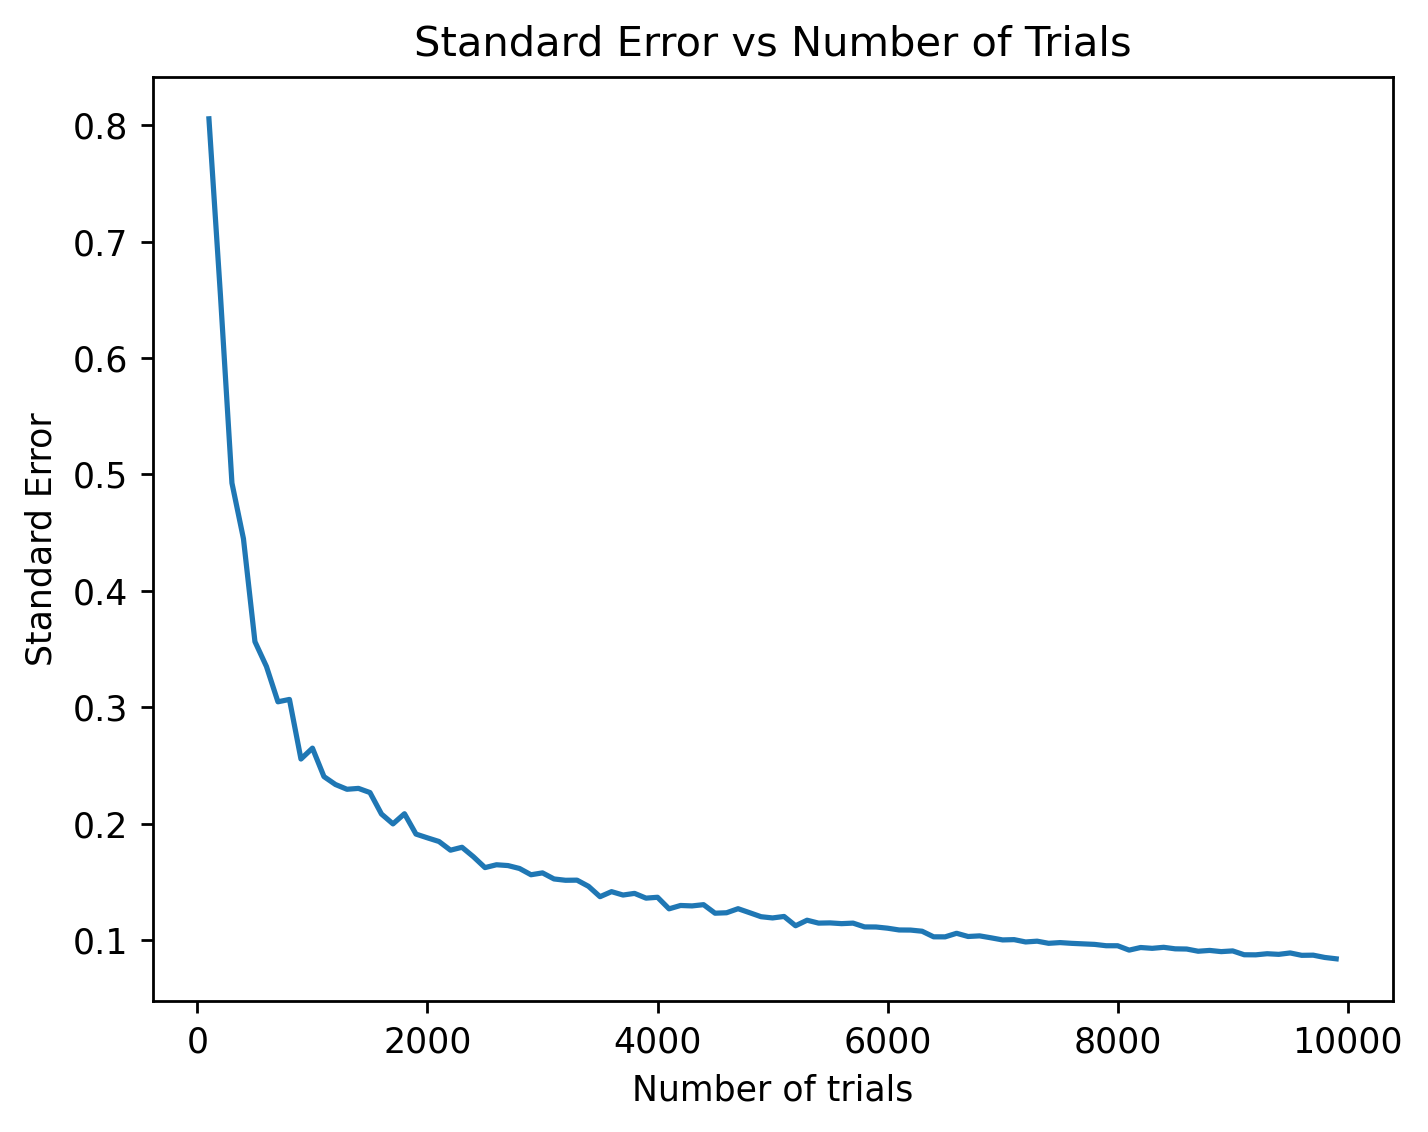

In [24]:
plt.figure(dpi=250)
plt.plot(m, std_errors)
plt.xlabel("Number of trials")
plt.ylabel("Standard Error")
plt.title("Standard Error vs Number of Trials")
plt.show()

In [92]:
# Parameters
T = 1.0
K = 99
r = 0.06
S0 = 100 
delta_t = 1/252
N = int(T/delta_t)
m = np.arange(100, 10000, 100)
# Monte Carlo Simulation for option pricing for volatality = 0.5
sigma = 0.5
option_values2= []
std_errors2 = []
lower2 = []
upper2 = []
for M in tqdm(m):
    option_value, sd_error , ml, mu   = priceOption(S0, r, delta_t, N, sigma, K, M,"put")
    option_values2.append(option_value)
    std_errors2.append(sd_error)
    lower2.append(ml)
    upper2.append(mu)

100%|██████████| 99/99 [17:09<00:00, 10.40s/it]


In [93]:
# Option price from black scholes for volatality = 0.5
option_BS2 = blackScholes(S0, K, 0, T, r, sigma)

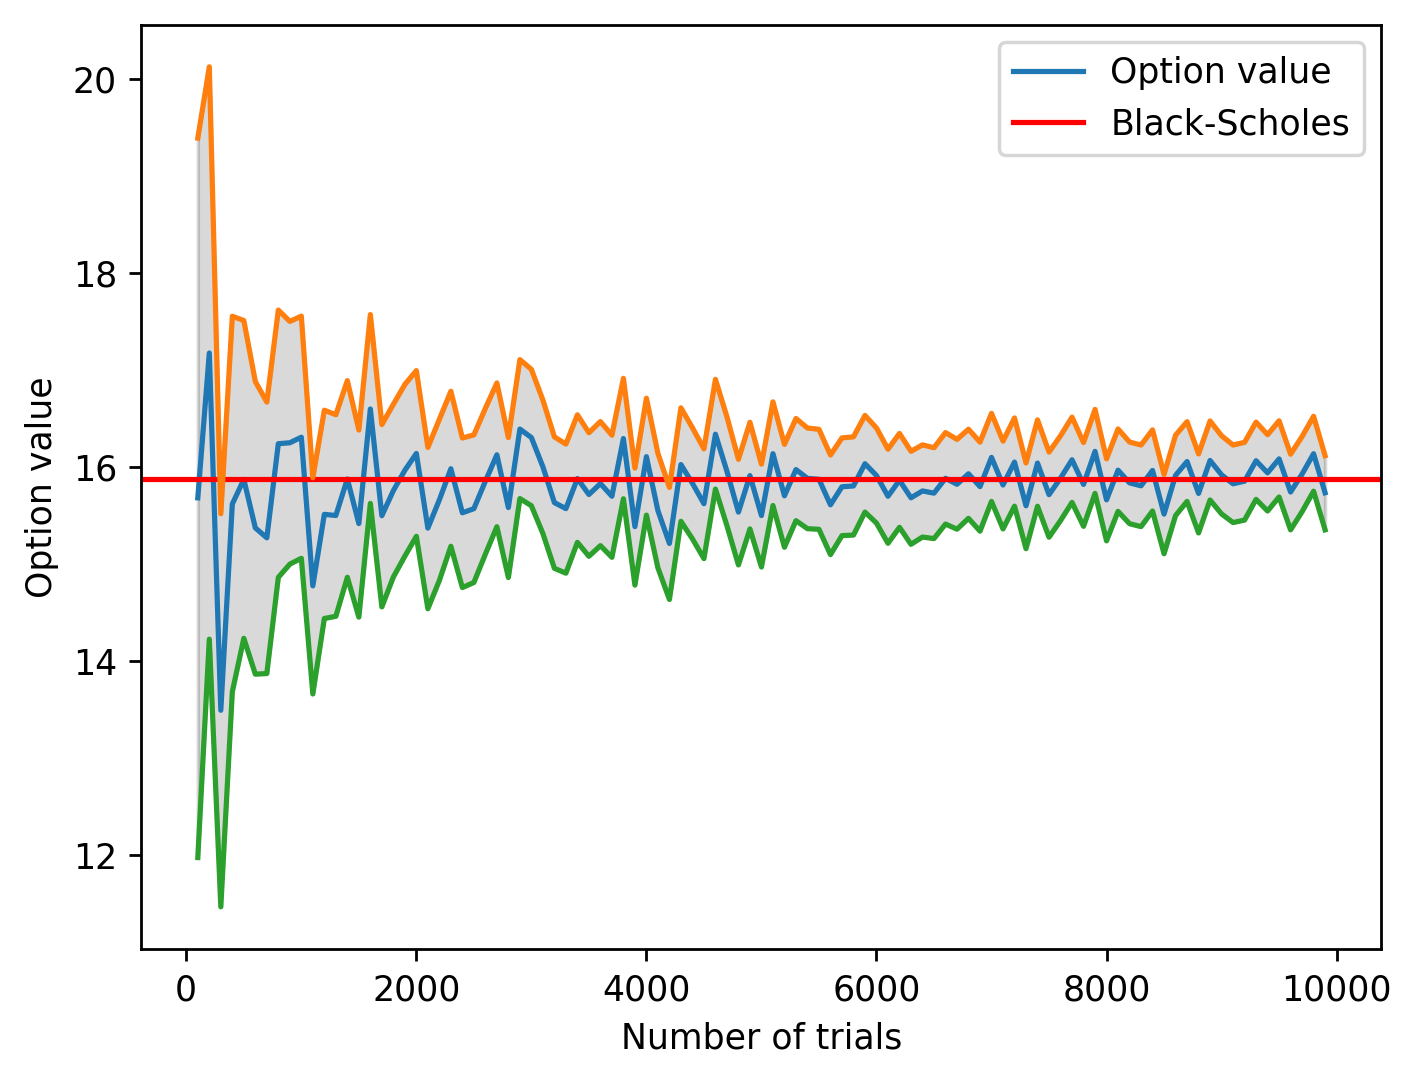

In [96]:
# Plot for option pricing for volatality = 0.5 using Monte Carlo
plt.figure(dpi=250)
plt.plot(m, option_values2, label='Option value')
plt.axhline(option_BS2, linestyle = "--", color = "red", label="Black-Scholes")
plt.plot(m, upper2, color = "lightblue")
plt.plot(m, lower2, color = "lightblue")
plt.fill_between(m, upper2, lower2, color="k", alpha=0.1)
plt.xlabel("Number of trials")
plt.ylabel("Option value")
plt.legend()
plt.show()

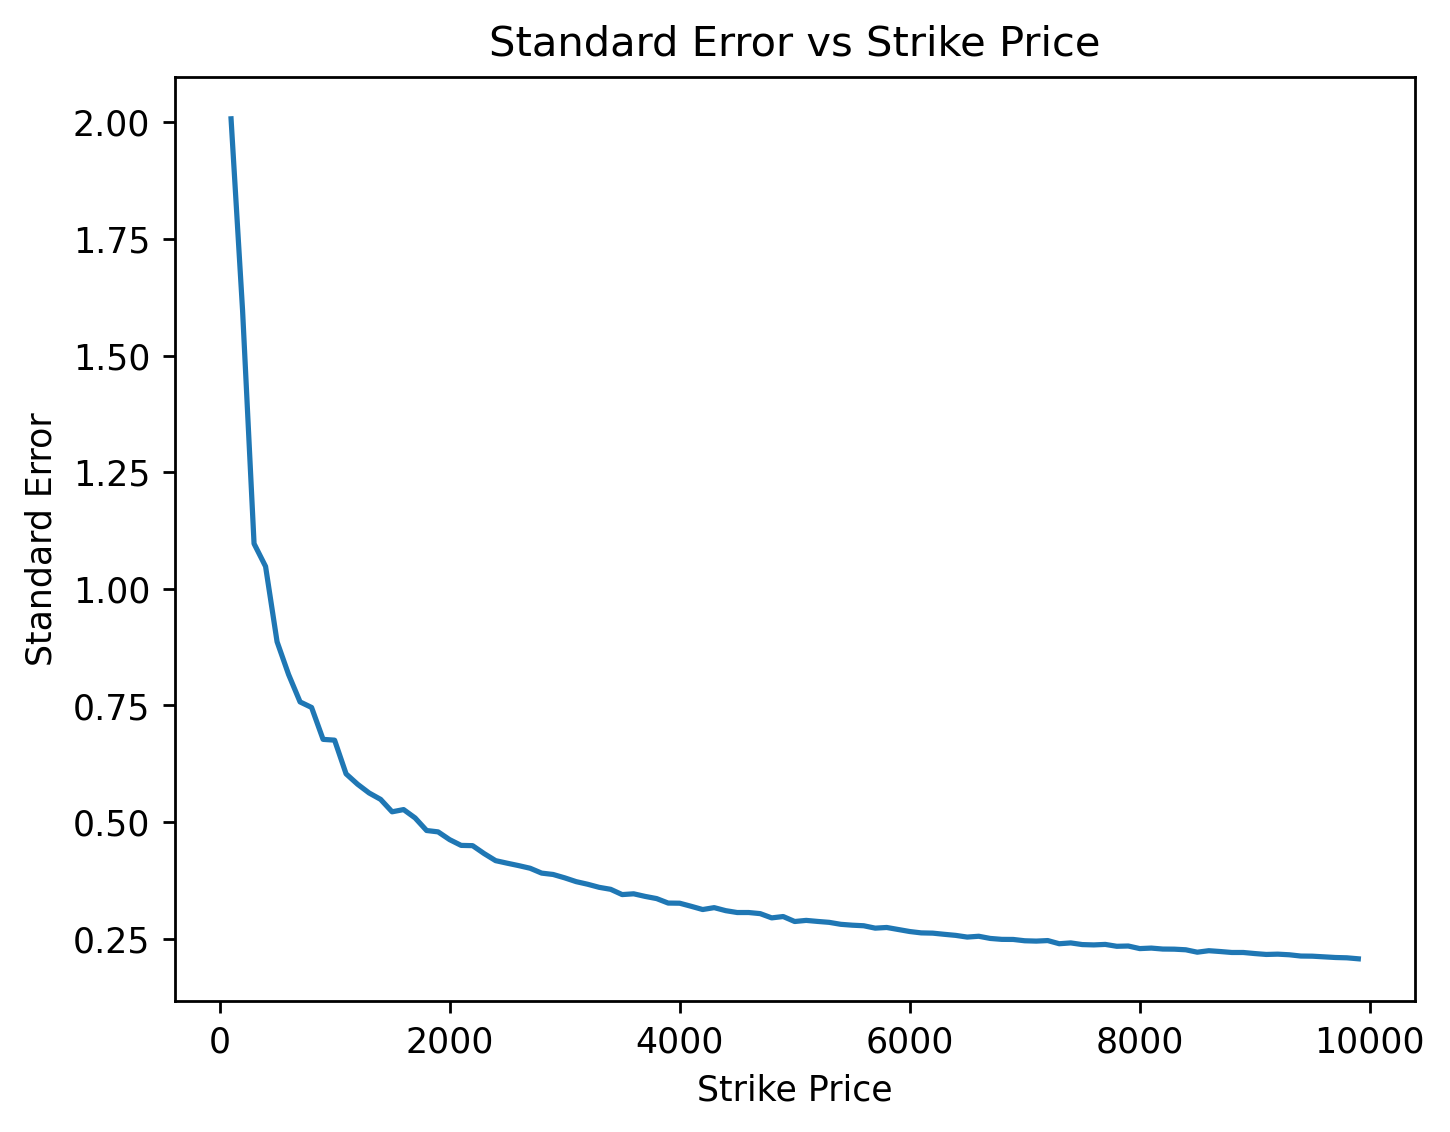

In [97]:
# Plot for standard error for volatality = 0.5 using Monte Carlo
plt.figure(dpi=250)
plt.plot(m, std_errors2)
plt.xlabel("Strike Price")
plt.ylabel("Standard Error")
plt.show()

##### Varying strike Price

In [68]:
# Parameters
K = np.arange(80, 120, 2)
T = 1.0
r = 0.06
S0 = 100 
sigma = 0.2
delta_t = 1/252
M = 5000
N = int(T/delta_t)


option_values3 = []
std_errors3 = []
lower3 = []
upper3 = []

for k in tqdm(K):
    option_value, sd_error , ml, mu  = priceOption(S0, r, delta_t, N, sigma, k, M, "put")
    option_values3.append(option_value)
    std_errors3.append(sd_error)
    lower3.append(ml)
    upper3.append(mu)

100%|██████████| 20/20 [13:03<00:00, 39.19s/it]


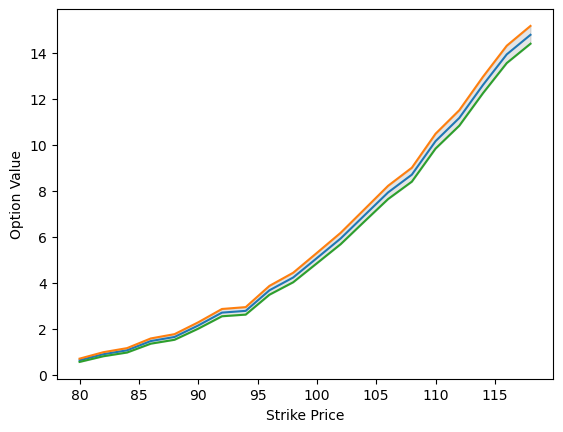

In [71]:
##Plotting the option values
plt.plot(K, option_values3)
plt.plot(K, upper3)
plt.plot(K, lower3)
plt.xlabel("Strike Price")
plt.ylabel("Option Value")
plt.fill_between(K, upper3, lower3, color="k", alpha=0.1)

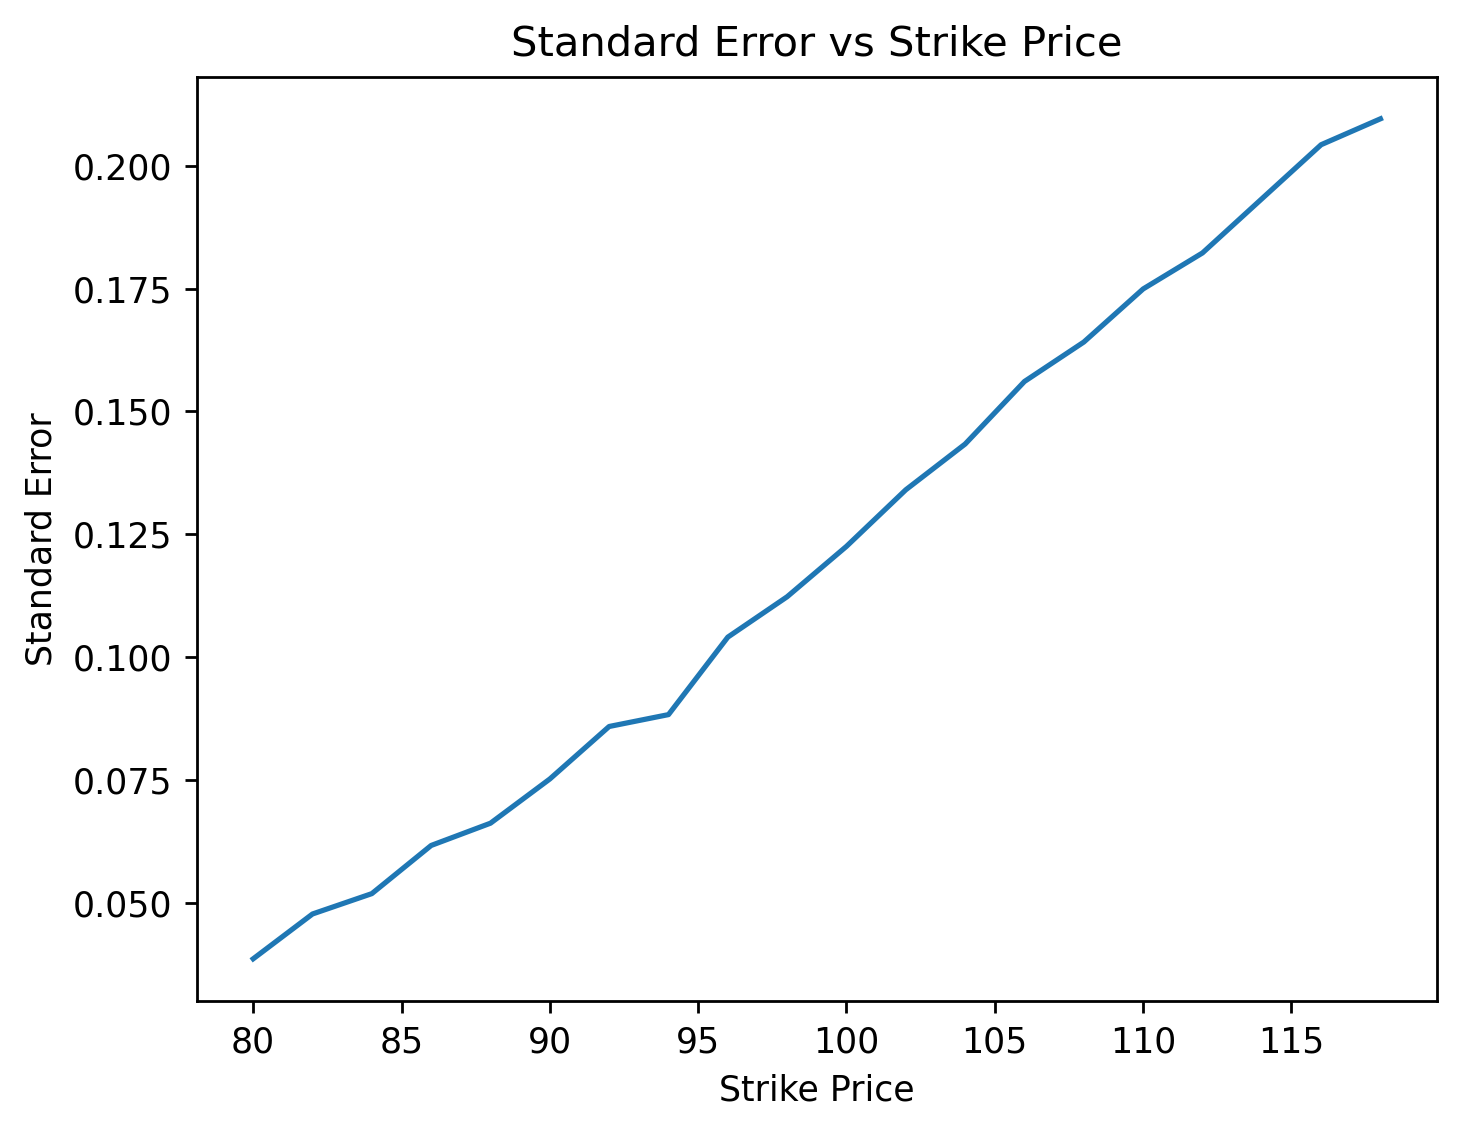

In [81]:
plt.figure(dpi=250)
plt.plot(K, std_errors3)
plt.xlabel("Strike Price")
plt.ylabel("Standard Error")
plt.title("Standard Error vs Strike Price")
plt.show()

### Varying volatality in Monte Carlo 

In [ ]:
# Parameters
vols = np.arange(0.1, 0.5, 0.01)
K = 99
T = 1.0
r = 0.06
S0 = 100 
sigma = 0.2
delta_t = 1/252
M = 5000
N = int(T/delta_t)
option_values = []
for vol in vols:
    option_value = priceOption(S0, r, delta_t, N, vol, K, M, "call")
    m.append(M)
    option_values.append(option_value)

In [ ]:
##Plotting the option values
plt.plot(vols, option_values)
plt.xlabel("Volatality")
plt.ylabel("Option Value")

### Part I - B

##### Milstein - Heston Model

In [30]:
## Milstein Variance Process
def m_Heston(k, dt, vol_of_vol, theta, corr, r, S0, Barrirer, K):
    prev_v = 0
    prev_S = S0
    Zv = np.random.normal()
    Z2 = np.random.normal()
    Zs = corr * Zv + (1 - corr**2) * Z2
    #variance = [prev_v]
    #assetPrice = [prev_S]
    
    for _ in np.arange(dt, 1., dt):
        vplus = max(0, prev_v)
        next_v = prev_v + k * (theta - vplus) * dt + vol_of_vol * np.sqrt(vplus * dt) * Zv + vol_of_vol ** 2 * dt * (Zv**2-1)/4
        next_S = prev_S + r * prev_S * dt + np.sqrt(vplus * dt) * Zs * prev_S + vplus * prev_S* dt * (Zs ** 2 - 1)/2
        prev_v = next_v
        if next_S >= Barrirer:
            return 0
        #variance.append(prev_v)
        #assetPrice.append(next_S)
    payOff = max(0, next_S - K)
    
    return payOff
        

In [27]:
def approximateOptionPrice_MH(k, dt, vol_of_vol, theta, corr, r, S0, B, K):
    
    payoffs_MH = []
    for _ in range(10000):
        payoff = m_Heston(k, dt, vol_of_vol, theta, corr, r, S0, B, K)
        payoffs_MH.append(payoff)
    option_approx = np.mean(payoffs_MH) * np.exp(-r* T)
    
    return option_approx


## Analysis

In [58]:
#### Initial Parameters
r = 0.05
theta = 0.04
k = 2
vol_of_vol = 0.1
corr = - 0.7
dt = 1/252
S0 =100
T = 1.0
K = 100
Barrier = np.arange(90, 120, 0.5)

#### Variation in Barrier

In [59]:
## Approximating the option price using Milstein Variance Process with Varying Barrier
option_prices_B = []
for B in tqdm(Barrier):
    option_approx = approximateOptionPrice_MH(k, dt, vol_of_vol, theta, corr, r, S0, B, K)
    option_prices_B.append(option_approx)   

100%|██████████| 60/60 [02:04<00:00,  2.08s/it]


Text(0, 0.5, 'Option Value')

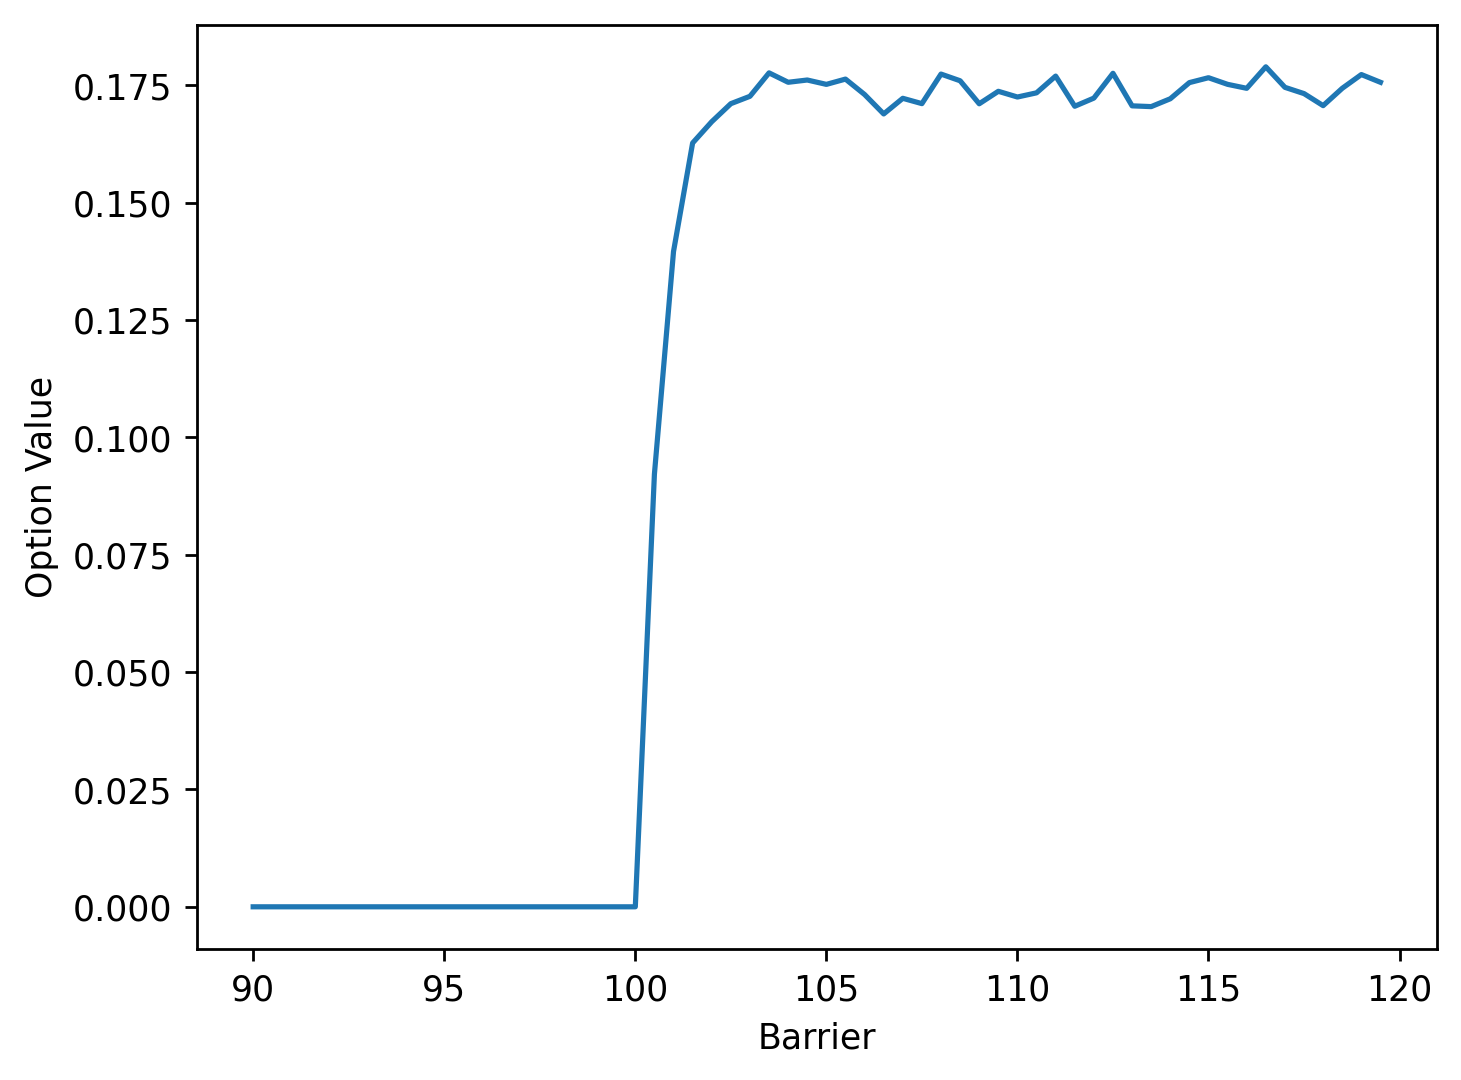

In [60]:
# Plotting the option prices for different barriers with Milsten Heston Model
plt.figure(dpi=250)
plt.plot(Barrier, option_prices_B)
plt.xlabel("Barrier")
plt.ylabel("Option Value")


#### Variation in Correlation

In [61]:
#### Initial Parameters
r = 0.05            # risk free rate
theta = 0.04        # long term variance
k = 2               # mean reversion
vol_of_vol = 0.1    # volatility of volatility
dt = 1/252          # time step
S0 =100             # initial stock price
T = 1.0             # time to maturity
K = 100             # strike price            
B = 120             # barrier         
#Correlation
corr = np.arange(-1, 1.1, 0.1)

In [62]:
option_prices_corr = []
for Correlation in tqdm(corr):
    option_approx = approximateOptionPrice_MH(k, dt, vol_of_vol, theta, Correlation, r, S0, B, K)
    option_prices_corr.append(option_approx)

100%|██████████| 21/21 [01:07<00:00,  3.21s/it]


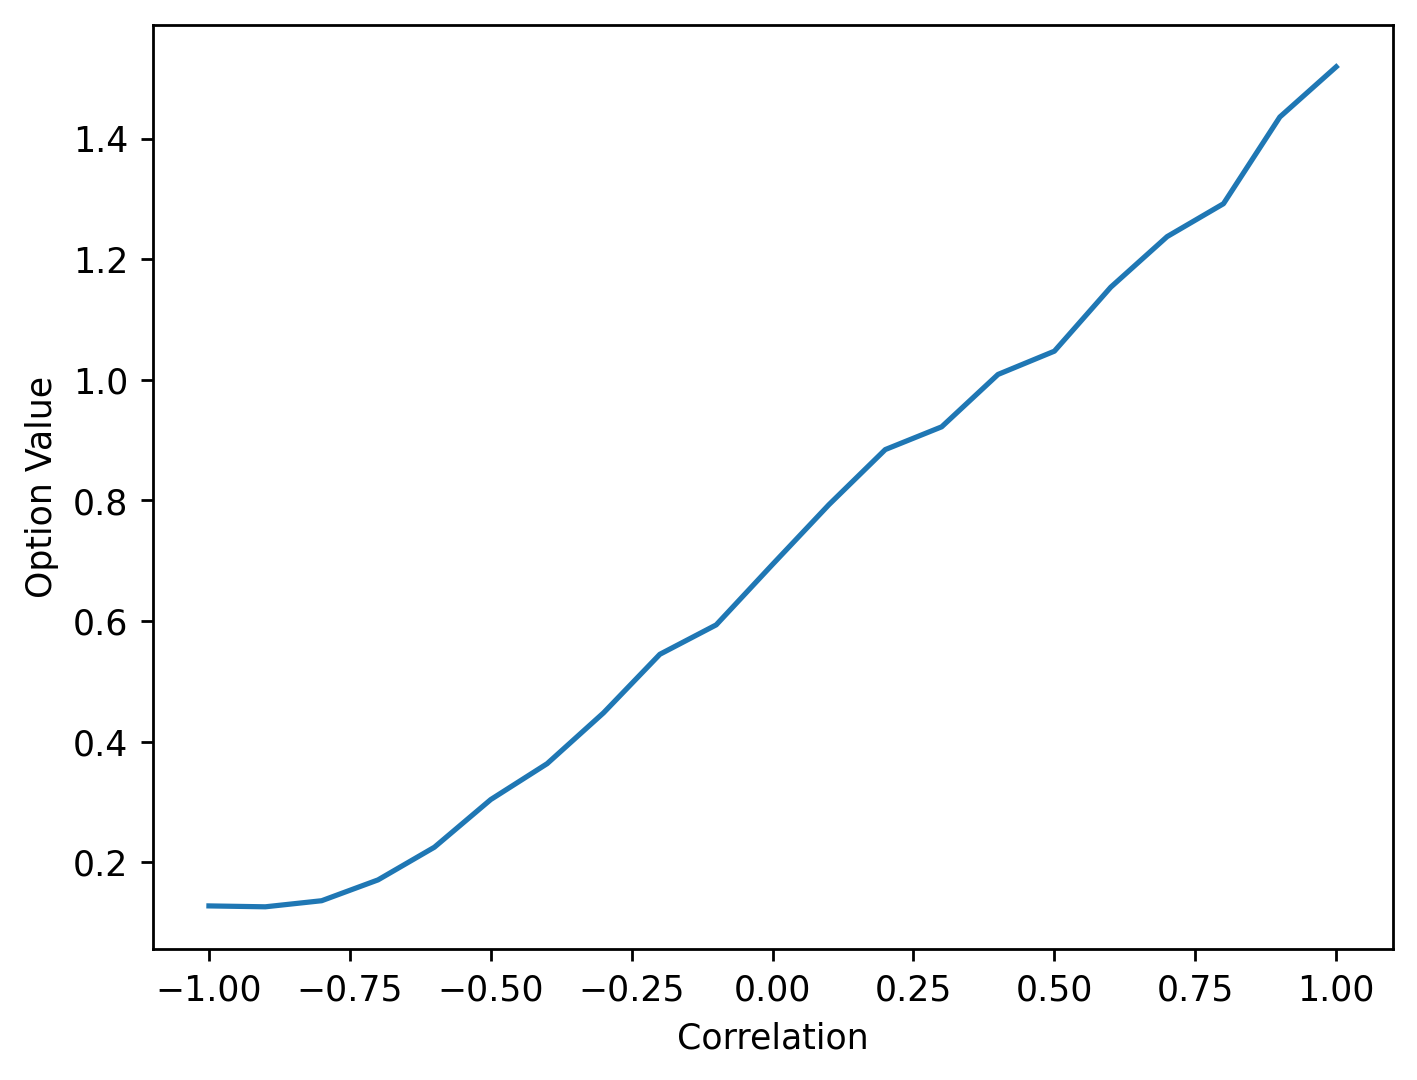

In [63]:
# Plotting the option prices for different correlation with Milsten Heston Model
plt.figure(dpi=250)
plt.plot(corr, option_prices_corr)
plt.xlabel("Correlation")
plt.ylabel("Option Value")
plt.show()

#### Variation in Vol of Vol

In [75]:
#### Initial Parameters
r = 0.05            # risk free rate
theta = 0.04        # long term variance
k = 2               # mean reversion
corr = - 0.7        # correlation
dt = 1/252          # time step
S0 =100             # initial stock price
T = 1.0             # time to maturity
K = 100             # strike price            
B = 120             # barrier         
#Correlation
vol_of_vol = np.arange(0, 1, 0.025)

In [71]:
# Approximating the option price using Milstein Variance Process with Varying Volatility of Volatility
option_prices_vol_of_vol = []
for volOfvol in tqdm(vol_of_vol):
    option_approx = approximateOptionPrice_MH(k, dt, volOfvol, theta, corr, r, S0, B, K)
    option_prices_vol_of_vol.append(option_approx)

100%|██████████| 40/40 [02:11<00:00,  3.29s/it]


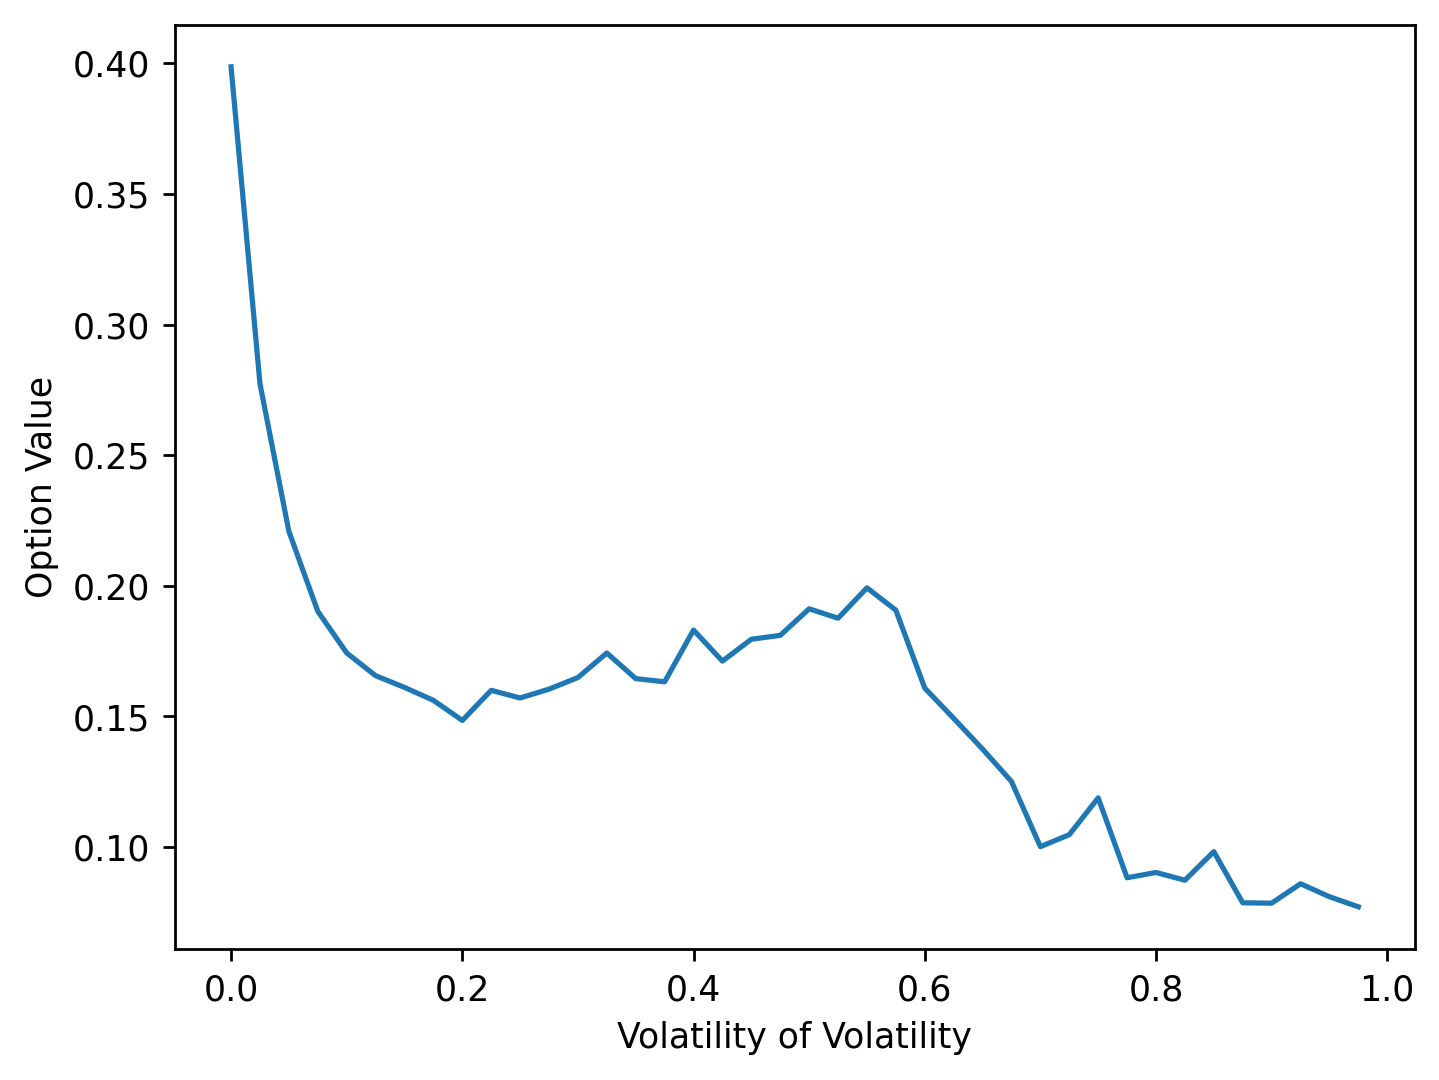

In [76]:
# Plotting the option prices for different volatility of volatility with Milsten Heston Model
plt.figure(dpi=250)
plt.plot(vol_of_vol, option_prices_vol_of_vol)
plt.xlabel("Volatility of Volatility")
plt.ylabel("Option Value")
plt.show()

##### Variation in Mean Reversion

In [79]:
#### Initial Parameters
r = 0.05            # risk free rate
theta = 0.04        # long term variance
vol_of_vol = 0.1      # volatility of volatility
corr = - 0.7        # correlation
dt = 1/252          # time step
S0 =100             # initial stock price
T = 1.0             # time to maturity
K = 100             # strike price            
B = 120             # barrier         
# Mean Reversion
k = np.arange(0, 10, 0.05)

In [80]:
# Approximating the option price using Milstein Variance Process with Varying Mean Reversion
option_prices_k = []
for k_ in tqdm(k):
    option_approx = approximateOptionPrice_MH(k_, dt, vol_of_vol, theta, corr, r, S0, B, K)
    option_prices_k.append(option_approx)

100%|██████████| 200/200 [10:40<00:00,  3.20s/it]


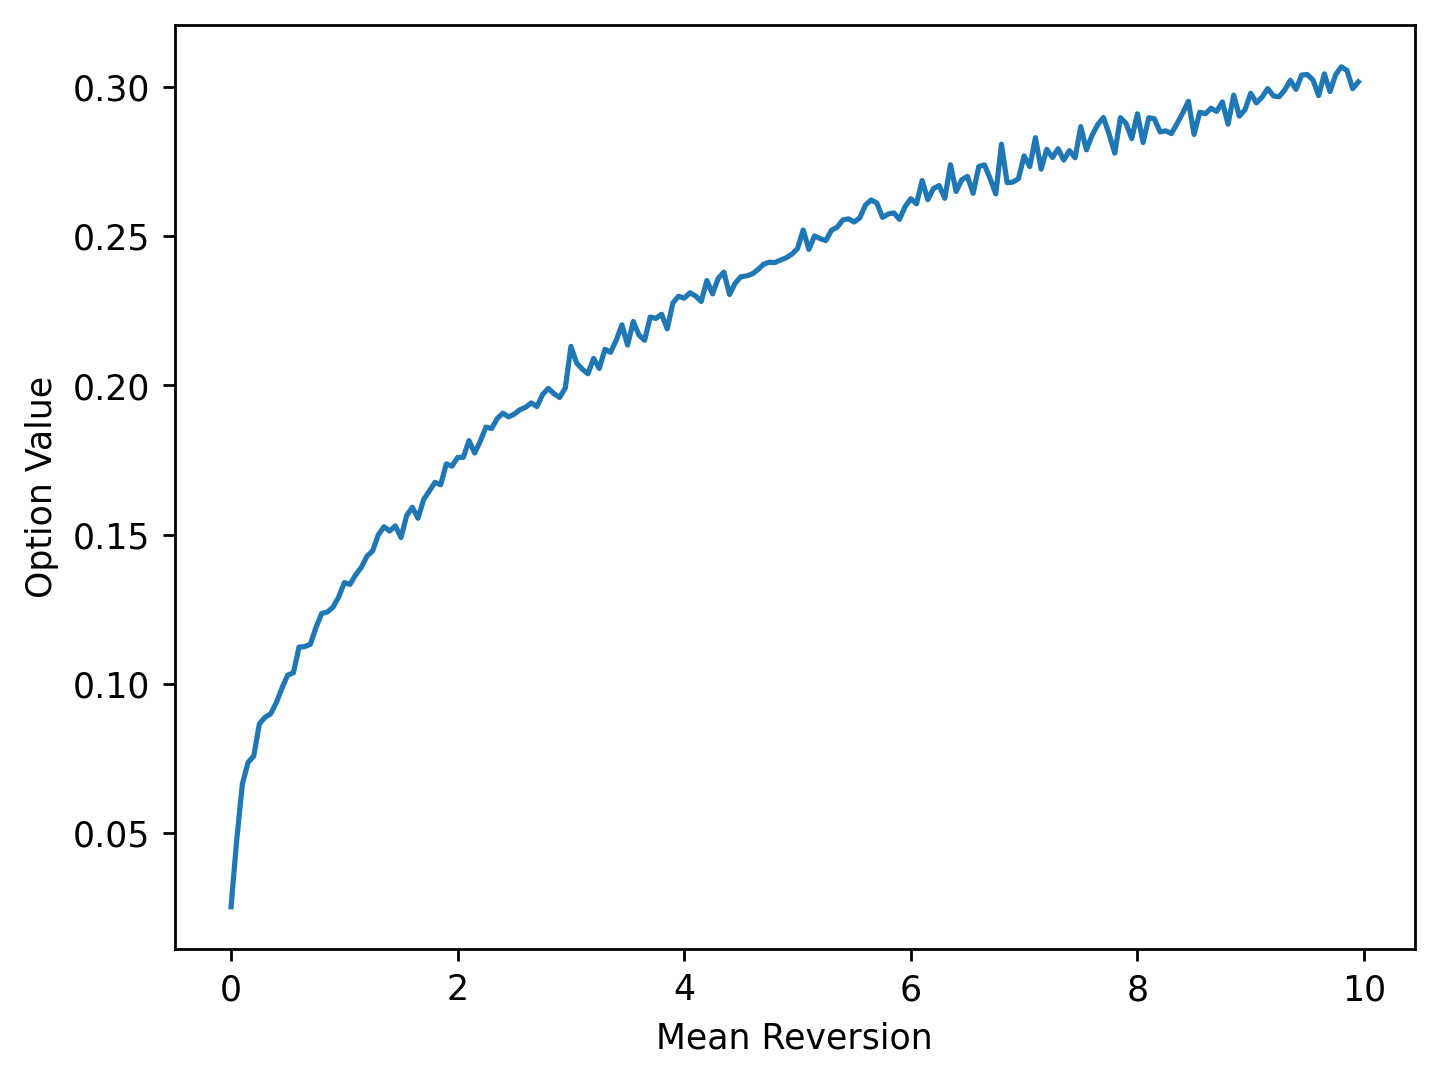

In [81]:
# Plotting the option prices for different mean reversion with Milsten Heston Model
plt.figure(dpi=250)
plt.plot(k, option_prices_k)
plt.xlabel("Mean Reversion")
plt.ylabel("Option Value")
plt.show()

### Variance Reduction

In [82]:
def calculateAsianOptionPrice_Analytical(riskfree_rate, Current_S, StrikeP, T, N, vol_stockP,  ):
    """
    Function to calculate the Asian option price using analytical method
    
    Args:
        riskfree_rate : risk free rate
        Current_S : Current stock price
        T : Maturity time
        N : Number of times the stock price is observed
        vol_stockP : Volatility of the stock price
    
    Returns:
        option_price : Option price
    """
    sigma_tilda = vol_stockP * np.sqrt((2 * N + 1) / (6 * (N + 1)))
    r_tilda = 0.5 * (riskfree_rate - 0.5 * vol_stockP ** 2)  + sigma_tilda ** 2
    d1 = (np.log(Current_S/StrikeP) + (r_tilda + 0.5 * sigma_tilda**2)*T)/(sigma_tilda * np.sqrt(T))
    d2 = (np.log(Current_S/StrikeP) + (r_tilda - 0.5 * sigma_tilda**2)*T)/(sigma_tilda * np.sqrt(T))
    optionValue = np.exp(-riskfree_rate * T) * (Current_S * np.exp(r_tilda * T) * norm.cdf(d1) - StrikeP * norm.cdf(d2))
    
    return optionValue
